# Предсказание стоимости жилья <a id="intro"></a>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание" data-toc-modified-id="Описание-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание</a></span></li><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Предобработка-данных-и-EDA" data-toc-modified-id="Предобработка-данных-и-EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных и EDA</a></span></li><li><span><a href="#Построение-пайплайна" data-toc-modified-id="Построение-пайплайна-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Построение пайплайна</a></span></li><li><span><a href="#Обучение-модели-по-всем-признакам" data-toc-modified-id="Обучение-модели-по-всем-признакам-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение модели по всем признакам</a></span><ul class="toc-item"><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span></li><li><span><a href="#Кроссвалидация" data-toc-modified-id="Кроссвалидация-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Кроссвалидация</a></span></li><li><span><a href="#Параметры-и-показатели-на-тренировочных-данных" data-toc-modified-id="Параметры-и-показатели-на-тренировочных-данных-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Параметры и показатели на тренировочных данных</a></span></li><li><span><a href="#Показатели-на-тестовых-данных" data-toc-modified-id="Показатели-на-тестовых-данных-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Показатели на тестовых данных</a></span></li></ul></li><li><span><a href="#Обучение-модели-по-количественным-признакам" data-toc-modified-id="Обучение-модели-по-количественным-признакам-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обучение модели по количественным признакам</a></span><ul class="toc-item"><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span></li><li><span><a href="#Кроссвалидация" data-toc-modified-id="Кроссвалидация-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Кроссвалидация</a></span></li><li><span><a href="#Параметры-и-показатели-на-тренировочных-данных" data-toc-modified-id="Параметры-и-показатели-на-тренировочных-данных-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Параметры и показатели на тренировочных данных</a></span></li><li><span><a href="#Показатели-на-тестовых-данных" data-toc-modified-id="Показатели-на-тестовых-данных-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Показатели на тестовых данных</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Описание

Необхимо обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. 

**Задачи:**
- обучить модель и сделать предсказания на тестовой выборке;
- использовать метрики RMSE, MAE и R2 при оценке качества модели.

## Загрузка и подготовка данных

Импортируем необходимые библиотеки.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

Инициализируем Spark-сессию локально.

In [2]:
RANDOM_SEED = 2023

spark = SparkSession.builder.master("local").appName("house price prediction").getOrCreate()

24/01/05 01:15:30 WARN Utils: Your hostname, MacBook-Air-Basir.local resolves to a loopback address: 127.0.0.1; using 192.168.1.236 instead (on interface en0)
24/01/05 01:15:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/05 01:15:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Подгрузим данные.

In [3]:
housing = spark.read.load("housing.csv",  format="csv", inferSchema=True, header=True, sep=",")

In [4]:
housing.printSchema()
housing.show(5)

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR B

[В начало](#intro)

## Предобработка данных и EDA

Прежде всего посмотрим на корректность данных. Есть ли дубликаты в данных?

In [5]:
housing.exceptAll(housing.dropDuplicates()).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



Дубликатов нет, есть ли нули в данных?

In [6]:
housing.select([F.count(F.when((F.col(c)==0), c)).alias(c) for c in housing.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



Нулей нет, есть ли пропуски в данных?

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



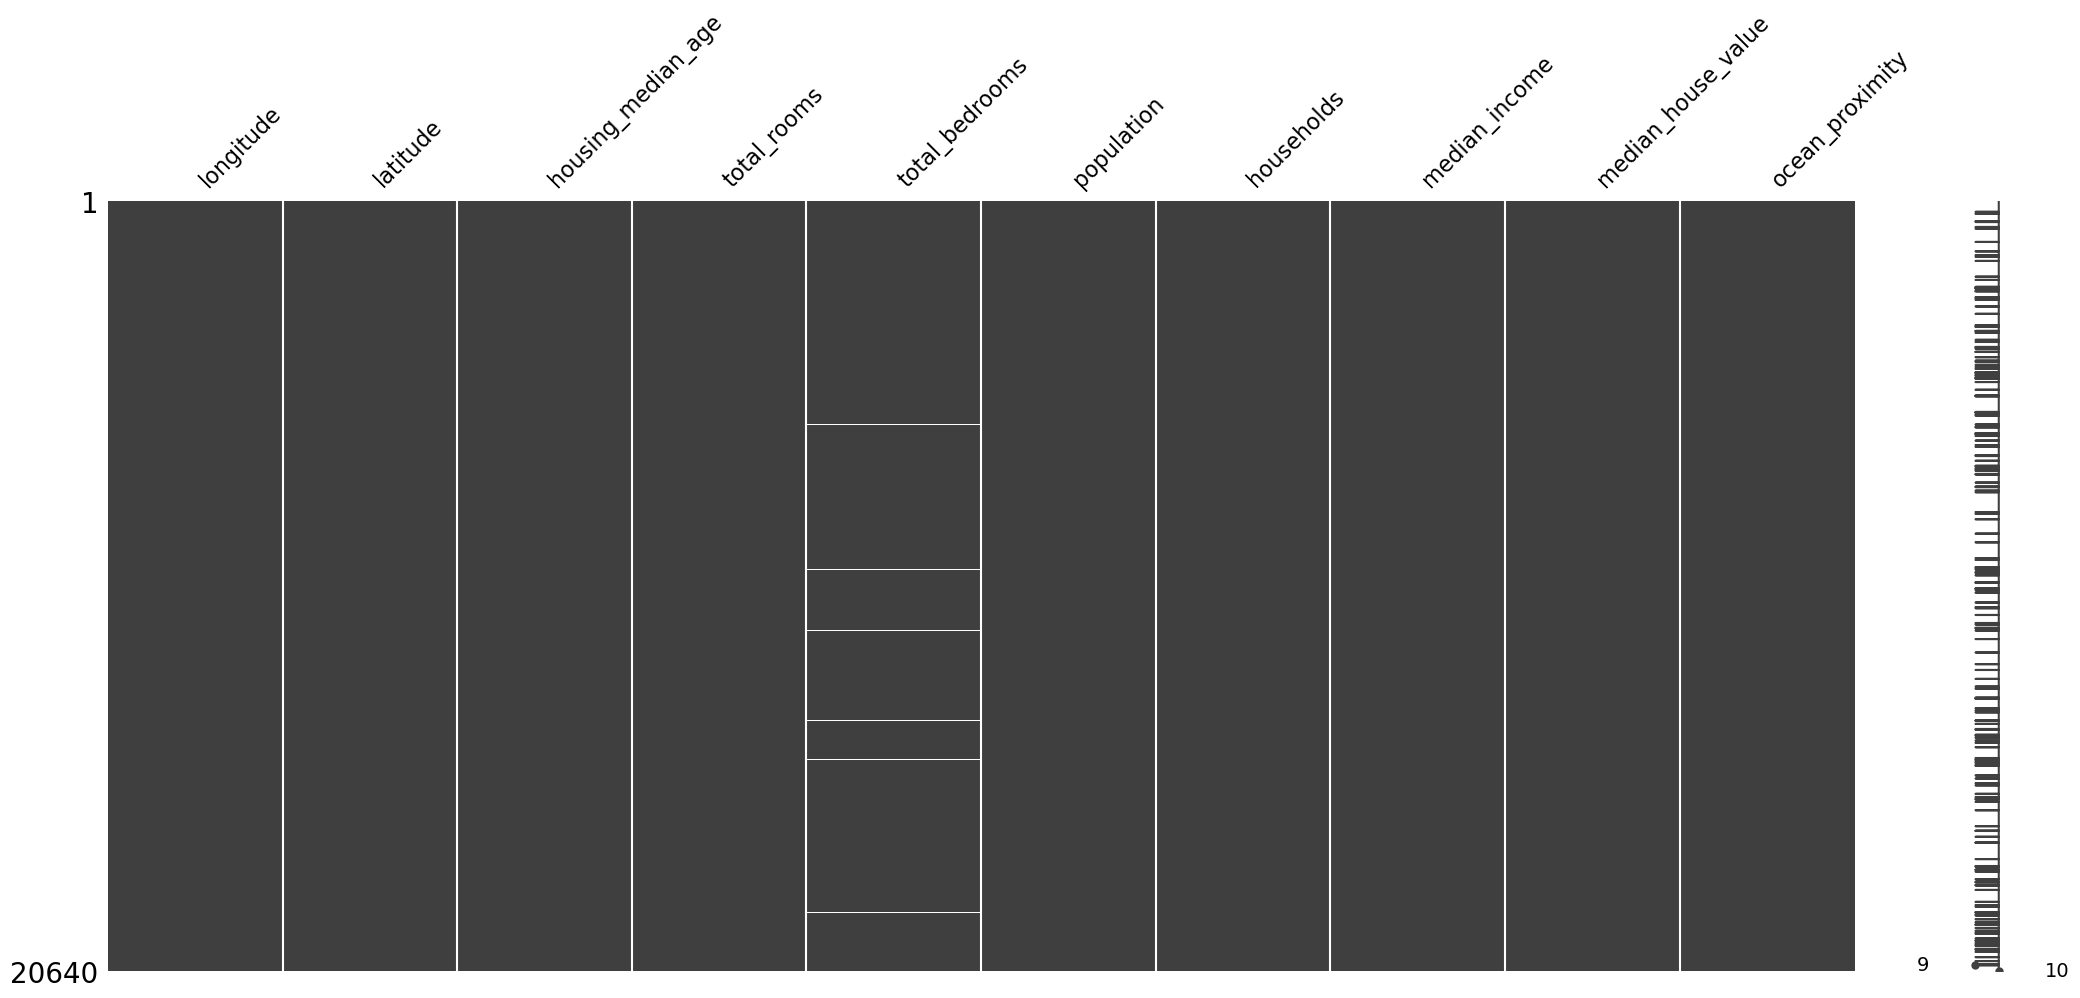

In [7]:
housing.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in housing.columns]).show()
msno.matrix(housing.toPandas());

Пропуски наблюдаются только в одном столбце, который содержит информацию о количестве спальных комнат в домах жилого массива. Хорошая новость, пропусков не так много, всего 207 штук из 20640. Посмотрим на часть из этих пропусков.

In [8]:
housing.filter(F.col("total_bedrooms").isNull()).show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.16|   37.77|              47.0|     1256.0|          NULL|     570.0|     218.0|        4.375|          161900.0|       NEAR BAY|
|  -122.17|   37.75|              38.0|      992.0|          NULL|     732.0|     259.0|       1.6196|           85100.0|       NEAR BAY|
|  -122.28|   37.78|              29.0|     5154.0|          NULL|    3741.0|    1273.0|       2.5762|          173400.0|       NEAR BAY|
|  -122.24|   37.75|              45.0|      891.0|          NULL|     384.0|     146.0|       4.9489|          247100.0|       NEAR BAY|
|   -122.1|   37.69|              

Поскольку пропусков не так много мы могли бы их удалить, однако, лучшим решением будет их заполнение.

In [9]:
housing.agg({"total_bedrooms": "mean"}).show()
housing.agg({"total_bedrooms": "median"}).show()

+-------------------+
|avg(total_bedrooms)|
+-------------------+
|  537.8705525375618|
+-------------------+

+----------------------+
|median(total_bedrooms)|
+----------------------+
|                 435.0|
+----------------------+



Остановимся на медианном количестве спальных комнат в жилых массивах и заполним им пропуски.

In [10]:
housing = housing.na.fill(435.0, "total_bedrooms")

Проверим остались ли пропуски в данных?

In [11]:
print(housing.count())
housing.filter(F.col("total_bedrooms").isNull()).show(5)

20640
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [12]:
housing.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

Пропусков нет, двигаемся дальше. Посмотрим на корреляцию данных.

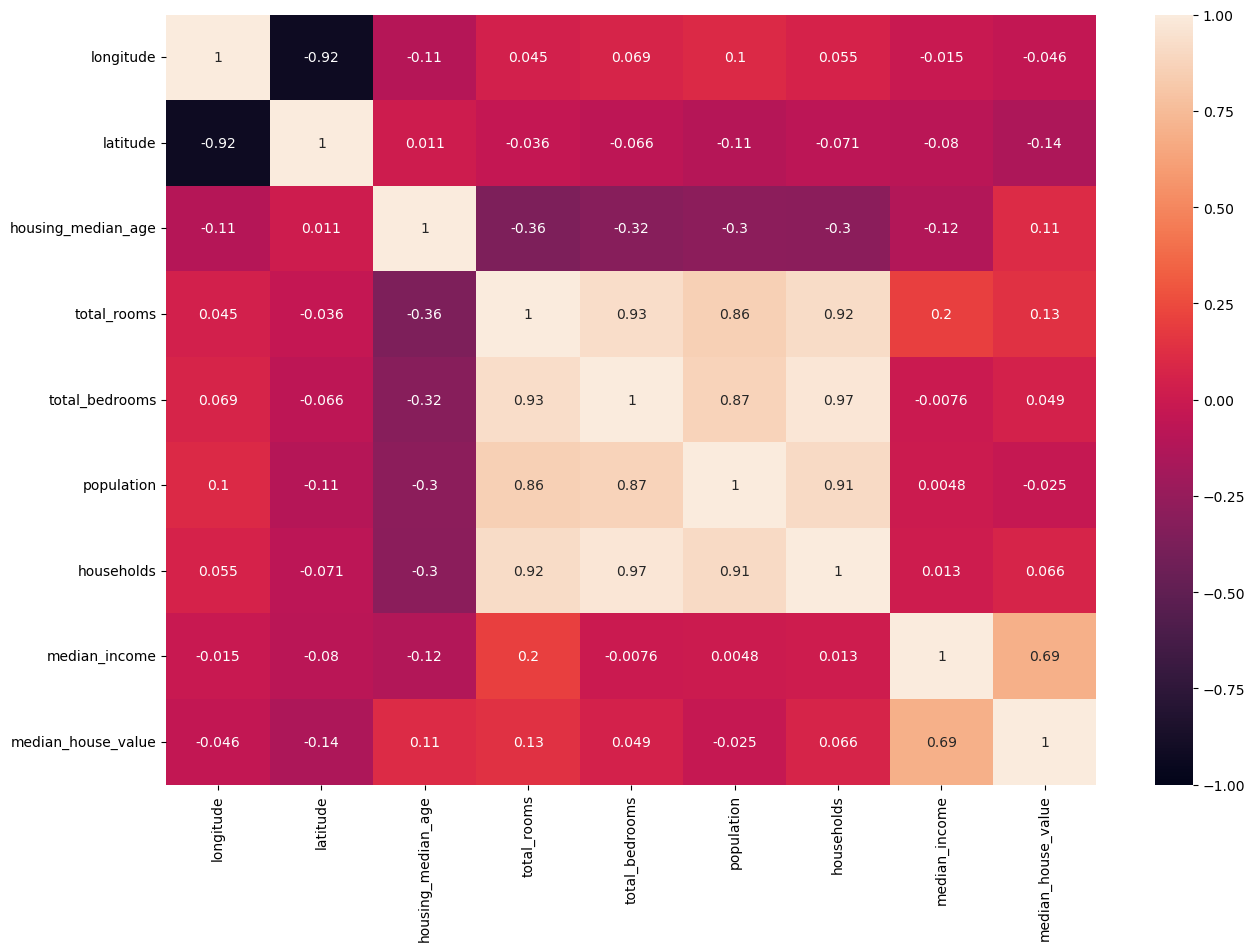

In [13]:
plt.figure(figsize = (15, 10))
(
    sns.heatmap(housing
             .toPandas()
             .select_dtypes("float")
             .corr(), 
                vmin=-1, 
                vmax=1,
                annot=True)
);

- На медианную стоимость домов в жилом массиве сильно влияет медианный доход жителей жилого массива, иными словами, чем выше доход жителей жилого массива, тем дороже их дома;
- Незначительно на медианную стоимость домов влияет медианный возраст жильцов, то есть с ростом возраста людей растет стоимость их домов, что может быть по 2-ум причинам. Во-первых, с ростом возраста жильцов растут их доходы, то есть с возрастом жильцы становятся богаче, однако, корреляция между столбцами медианный возраст жильцов и медианный доход практически отсутствует. Во-вторых, жильцы могли купить дома в молодости и со временем в результате урбанизации цены на квартиры могли вырасти. Точно определить причину по имеющимся данным мы не можем;
- Также наблюдается совсем незначительная корреляция между количеством комнат в домах жилого массива и их медианной стоимостью, с ростом количества комнат растет и цена домов;
- Обратная зависимость с целевым признаком не наблюдается.

Также изучим распределение данных.

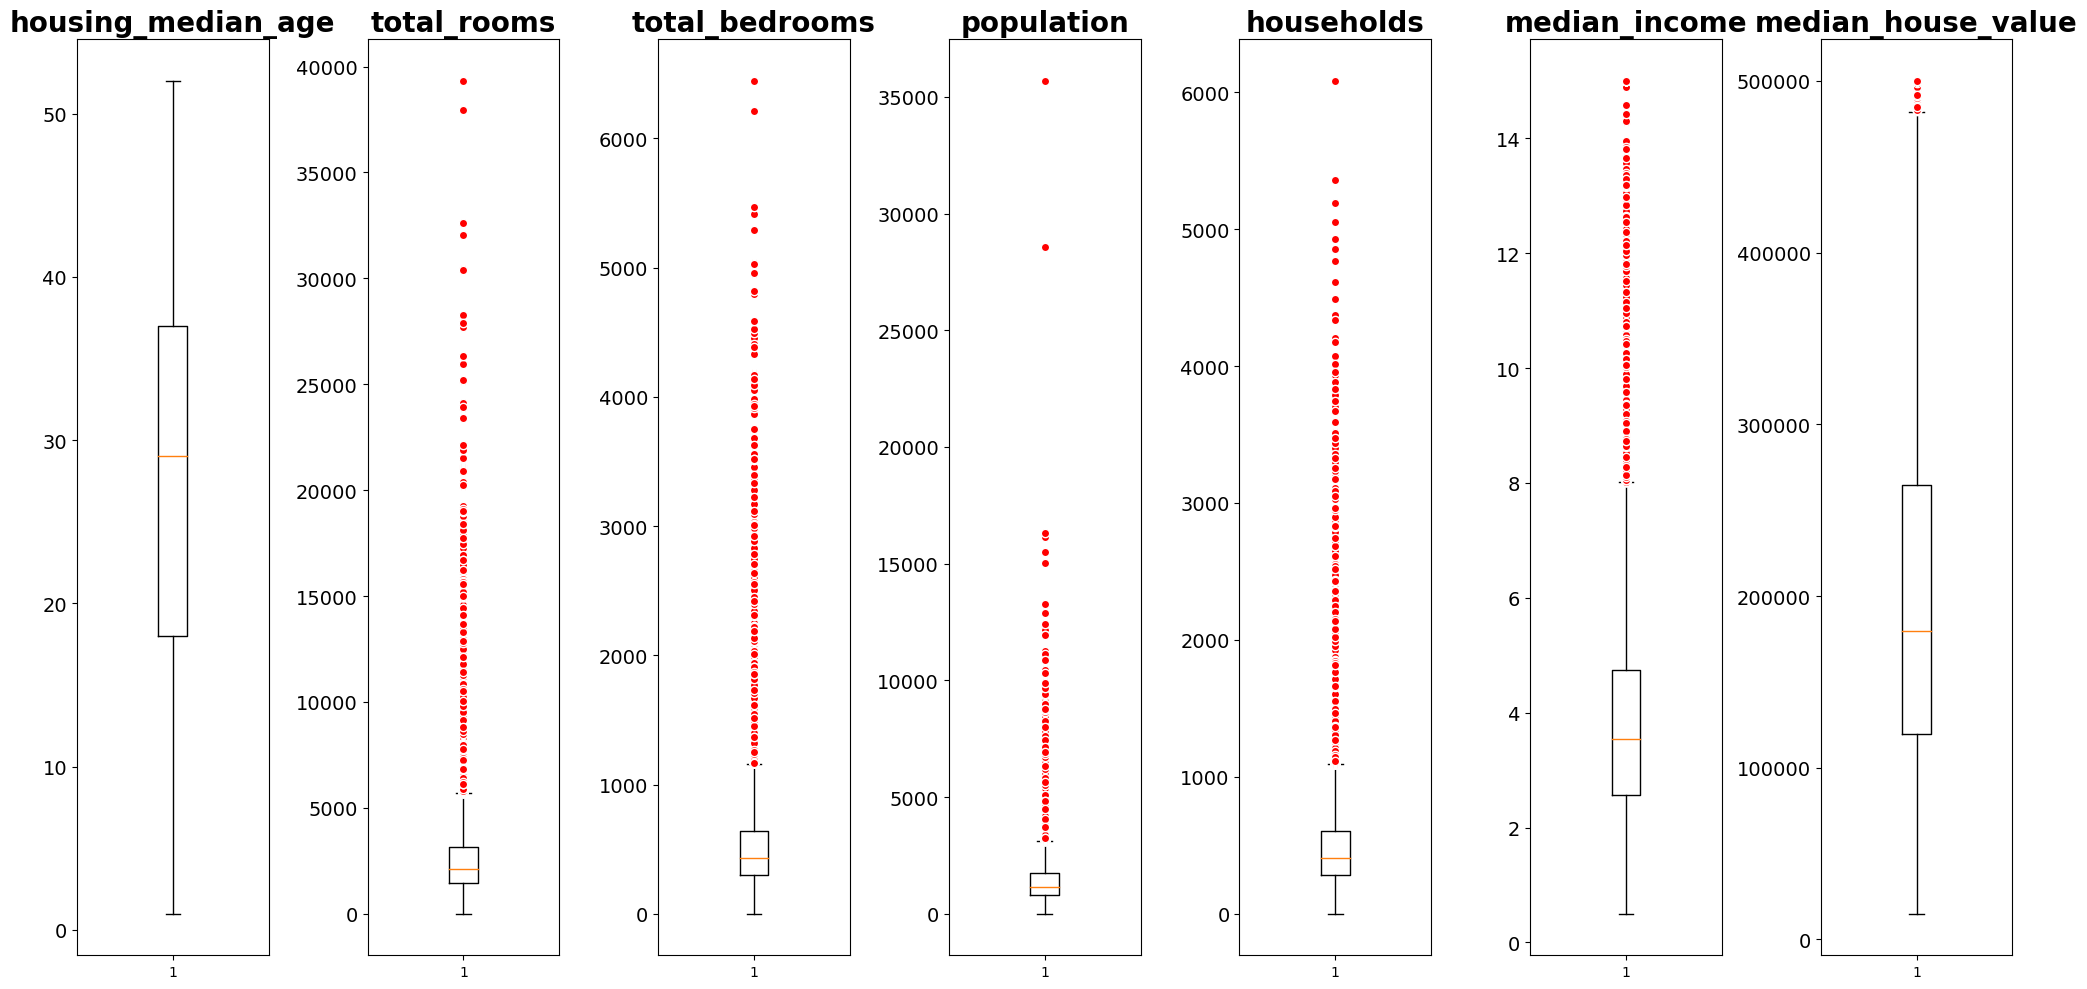

In [14]:
data = housing.select(["housing_median_age", 
                       "total_rooms", 
                       "total_bedrooms", 
                       "population",
                       "households",
                       "median_income",
                       "median_house_value"]).toPandas()

red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
fig, axs = plt.subplots(1, len(data.columns), figsize=(20,10))

for i, ax in enumerate(axs):
    ax.boxplot(data.iloc[:, i], flierprops=red_circle)
    ax.set_title(data.columns[i], fontsize=20,  fontweight='bold')
    ax.tick_params(axis='y',labelsize=14)
                            
plt.tight_layout()

- Медианный возраст жильцов примерно 30 лет, выбросы не наблюдаются, большая часть жильцов в возрасте от 18 до 38, обшая масса от 1 до 53 лет;
- В жилых массивах общее количество комнат в основном варьируется от 2 000 до 4 000, к выбросам не относятся количество комнат от 0 до 6 000 комнат. Все, что выше - выбросы. Причина выбросов простая, жилые массивы могут быть слишком разными, где то могут быть частные дома, где то многоэтажки. Поскольку в целом Калифорния одноэтажная, то нормой считается до 6 000 комнат в жилом массиве;
- В большинстве своем, жилые массивы имеют ло 300 до 700 спальных комант, максимум 1 100, все что выше также выбросы, причина нам известна;
- Количество проживающих в жилых массивах до 3 500 является нормой, выбросы выше 3 500;
- Количество домов в жилых массивах свыше 1 100 являются выбросами;
- Медианный доход от 0,2 до 8 норма, выше 8 выбросы. Исходя из данных непонятно за какой промежуток даны доходы, если за месяц то, возможно, единица измерения в тысячах долларов;
- Мединная стоимость жилья до 490 000 (скорее всего тыс. $), выбросов не так много.

Разобьем данные на категориальные и количественные.

In [15]:
categorical_cols = ["ocean_proximity"]
numerical_cols  = ["longitude",
                   "latitude",
                   "housing_median_age",
                   "total_rooms",
                   "total_bedrooms",
                   "population",
                   "households",
                   "median_income"]
target = "median_house_value" # целевую колонку выпишем в отедельную переменную.

In [16]:
housing.select(numerical_cols).describe().toPandas().T

24/01/05 01:15:40 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,0,1,2,3,4
summary,count,mean,stddev,min,max
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,39320.0
total_bedrooms,20640,536.8388565891473,419.39187792168866,1.0,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,15.0001


In [17]:
housing.select(target).describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,500001.0


Описательная статистика подтверждает наши слова.

In [18]:
housing.groupBy(categorical_cols).count().orderBy("count", ascending=False).show()

+---------------+-----+
|ocean_proximity|count|
+---------------+-----+
|      <1H OCEAN| 9136|
|         INLAND| 6551|
|     NEAR OCEAN| 2658|
|       NEAR BAY| 2290|
|         ISLAND|    5|
+---------------+-----+



Больше всего домов в одном часе от океана.

[В начало](#intro)

## Построение пайплайна

Для удоства все методы трансформации вынесем в пайплайн. Выпишем этапы.

In [19]:
# Переведем все категориальные текстовые колонки в категориальные числовые колонки
indexer = StringIndexer(inputCols=categorical_cols, 
                        outputCols=[c+"_idx" for c in categorical_cols]) 

# Переведем все в категориальные числовые колонки
encoder = OneHotEncoder(inputCols=[c+"_idx" for c in categorical_cols], 
                        outputCols=[c+"_ohe" for c in categorical_cols]) 

# Переведем все категориальные числовые колонки в единый вектор значений
categorical_assembler = VectorAssembler(inputCols=[c+"_ohe" for c in categorical_cols],
                                        outputCol="categorical_features")

# Переведем все количественные колонки в единый вектор значений
numerical_assembler = VectorAssembler(inputCols=numerical_cols,
                                      outputCol="numerical_features")

# Шкалируем все количественные колонки — чтобы сильные выбросы не смещали предсказания модели
standard_scaler = StandardScaler(inputCol="numerical_features",
                                outputCol="numerical_features_scaled")

all_features = ["categorical_features","numerical_features_scaled"]

# Объеденим количественные и категориальные колонки  в единый вектор значений
final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol="features") 

Создадим объект пайплайн и укажем в нем ранее созданные этапы-трасформаторы в правильном порядке.

In [20]:
pipe = Pipeline(stages=[indexer, 
                        encoder, 
                        categorical_assembler, 
                        numerical_assembler, 
                        standard_scaler,
                        final_assembler])

Используем пайплайн и посмотрим, что получилось.

In [21]:
piped_housing = pipe.fit(housing).transform(housing)
piped_housing.select(["categorical_features","numerical_features_scaled"]).show(5)

24/01/05 01:15:42 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+--------------------+-------------------------+
|categorical_features|numerical_features_scaled|
+--------------------+-------------------------+
|       (4,[3],[1.0])|     [-61.007269596069...|
|       (4,[3],[1.0])|     [-61.002278409814...|
|       (4,[3],[1.0])|     [-61.012260782324...|
|       (4,[3],[1.0])|     [-61.017251968579...|
|       (4,[3],[1.0])|     [-61.017251968579...|
+--------------------+-------------------------+
only showing top 5 rows



Все корректно, теперь разобьем данные на тренировочную и обучающую выборку.

In [22]:
train_data, test_data = piped_housing.randomSplit([.8,.2], seed=RANDOM_SEED)
print(train_data.count(), test_data.count()) 

16519 4121


[В начало](#intro)

## Обучение модели по всем признакам

Обучим модель на основе всех доступных признаков.

### Подбор гиперпараметров

Для того, чтобы получить лучшие результаты, мы переберем внутри кросвалидации наиболее основные гиперпараметры алгоритма линейной регрессии при помощи решетки подбора гиперпараметров. Метрикой кросвалидации оставим по умолчанию MSE. 

In [23]:
lr = LinearRegression(labelCol=target, featuresCol="features")

grid_search = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .addGrid(lr.regParam, [0.1, 0.5, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.1, 0.5, 1.0]) \
    .build()

evaluator = RegressionEvaluator(predictionCol='prediction',
                                labelCol='median_house_value')

[В начало](#intro)

### Кроссвалидация

Укажем созданные нами объекты в кросвалидации.

In [24]:
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=grid_search,
                    evaluator=evaluator,
                    numFolds=5)

cv_common = cv.fit(train_data)

24/01/05 01:15:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/05 01:15:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


[В начало](#intro)

### Параметры и показатели на тренировочных данных

Посмотрим какие результаты показывает лучшая модель кросвалидации.

In [25]:
print("Показатели модели:")
print("RMSE:", cv_common.bestModel.summary.rootMeanSquaredError)
print("MAE:", cv_common.bestModel.summary.meanAbsoluteError)
print("R2:",cv_common.bestModel.summary.r2)

Показатели модели:
RMSE: 68616.78199864207
MAE: 49918.022535469565
R2: 0.6448573799212087


И какие гиперпараметры считаются лучшими.

In [26]:
cv_common.bestModel.extractParamMap()

{Param(parent='LinearRegression_c328ec9d57bf', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LinearRegression_c328ec9d57bf', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0,
 Param(parent='LinearRegression_c328ec9d57bf', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35,
 Param(parent='LinearRegression_c328ec9d57bf', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LinearRegression_c328ec9d57bf', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearRegression_c328ec9d57bf', name='labelCol', doc='label column name.'): 'median_house_value',
 Param(parent='LinearRegression_c328ec9d57bf', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber.'): 

regParam = 1.0 \
maxIter = 100 \
elasticNetParam = 1.0

[В начало](#intro)

### Показатели на тестовых данных

Протестируем модель на тестовых данных.

In [27]:
predictions = cv_common.bestModel.transform(test_data)

predictedLabes = predictions.select("median_house_value", "prediction")
predictedLabes.show(5)

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           78300.0|126791.02890790999|
|           67000.0|152614.63825502433|
|           62500.0| 166848.7015528148|
|          100600.0|191905.58392986888|
|          104200.0|200616.77529637422|
+------------------+------------------+
only showing top 5 rows



In [28]:
def get_indicators():
    print("RMSE:", RegressionEvaluator(predictionCol = "prediction", labelCol = "median_house_value", metricName = "rmse").evaluate(predictions))
    print("MAE:", RegressionEvaluator(predictionCol = "prediction", labelCol = "median_house_value", metricName = "mae").evaluate(predictions))
    print("R2:", RegressionEvaluator(predictionCol = "prediction", labelCol = "median_house_value", metricName = "r2").evaluate(predictions))
get_indicators()

RMSE: 69575.5343614717
MAE: 49835.600657270596
R2: 0.6427037728059677


Показатели неплохие, однако, сравнивать несчем. Обучим модель только на количественных признаках и сравним результаты обеих моделей.

[В начало](#intro)

## Обучение модели по количественным признакам

Проделываем все тоже самое, с использованием только количественных признаков.

### Подбор гиперпараметров

In [29]:
lr = LinearRegression(labelCol=target, featuresCol="numerical_features_scaled")

grid_search = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .addGrid(lr.regParam, [0.1, 0.5, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.1, 0.5, 1.0]) \
    .build()

evaluator = RegressionEvaluator(predictionCol='prediction',
                                labelCol='median_house_value')

[В начало](#intro)

### Кроссвалидация

In [30]:
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=grid_search,
                    evaluator=evaluator,
                    numFolds=5)

cv_noncat= cv.fit(train_data)

[В начало](#intro)

### Параметры и показатели на тренировочных данных

In [31]:
print("Показатели модели:")
print("RMSE:", cv_noncat.bestModel.summary.rootMeanSquaredError)
print("MAE:", cv_noncat.bestModel.summary.meanAbsoluteError)
print("R2:",cv_noncat.bestModel.summary.r2)

Показатели модели:
RMSE: 69483.108359299
MAE: 50942.66678259918
R2: 0.6358330084408951


Показатели хуже, чем на предыдущей модели.

In [32]:
cv_noncat.bestModel.extractParamMap()

{Param(parent='LinearRegression_07b0ffff98a8', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LinearRegression_07b0ffff98a8', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5,
 Param(parent='LinearRegression_07b0ffff98a8', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35,
 Param(parent='LinearRegression_07b0ffff98a8', name='featuresCol', doc='features column name.'): 'numerical_features_scaled',
 Param(parent='LinearRegression_07b0ffff98a8', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearRegression_07b0ffff98a8', name='labelCol', doc='label column name.'): 'median_house_value',
 Param(parent='LinearRegression_07b0ffff98a8', name='loss', doc='The loss function to be optimized. Supported options: squared

regParam = 0.5 \
maxIter = 50 \
elasticNetParam = 0.5

[В начало](#intro)

### Показатели на тестовых данных

In [33]:
predictions = cv_noncat.bestModel.transform(test_data)

predictedLabes = predictions.select("median_house_value", "prediction")
predictedLabes.show(5)

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           78300.0| 79744.89488400379|
|           67000.0|121103.73110878188|
|           62500.0|136000.45039957855|
|          100600.0|159601.93865147466|
|          104200.0|169162.29486639798|
+------------------+------------------+
only showing top 5 rows



In [34]:
get_indicators()

RMSE: 70595.73848535583
MAE: 50975.70732290709
R2: 0.6321486954368448


Показатели незначительно хуже, чем на предыдущей модели.

[В начало](#intro)

**Сохранение модели**

Сохраним лучшую модель для дальнейшего использования.

In [36]:
cv_common.bestModel.save("/Users/bashir/Projects/10/cv_common")

Завершим нашу Spark-сессию и освободим занятие мощности.

In [37]:
spark.stop()

## Выводы

- По итогам первичной обработки можно сказать, что данные не были сильно грязными, были выявляены пропуски и успешно устранены;
- По итогам EDA можно сказать, что для ML модели наиболее полезным оказалась колонка медианный доход, именно с ней наибольшая корреляция нашей целевой колонки;
- В большинстве данных имеются выбросы, самой основной причиной является разная степень урбанизации локаций жилых массивов;
- Для удобства был использован пайплайн с основными этапами трансформации колонок для модели машинного обучения, а также кросвалидация с подбором гиперпараметров при помощи решетки для выявления лушей модели;
- Были использованы 2 сценария обучения модели машинного обучения со всеми признаками и только с количественными признаками. Лучшие результаты показала модель, обученная по всем признакам, мы рекомендуем использовать именно ее.

[В начало](#intro)